In [9]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [10]:
data = pd.read_pickle('data/feat_period_12_raw_data_marco.pkl')
data.head()

,month,day,hour,ref_timestamp,idx_val_below_thr,metric,label,0,1,2,...,7,8,9,10,11,12,13,14,15,16
0,10,21,0,2021-10-21 00:00:00+00:00,0,10-248-50-179,0,0.295616,4.740116e-09,-0.885352,...,0.000064,0.295521,0.295727,0.295602,1.478080,0.0,-0.000169,1.0,1.500000,0.250000
1,10,21,6,2021-10-21 06:00:00+00:00,0,10-248-50-179,0,0.294538,1.182971e-06,-1.603186,...,0.002059,0.292865,0.295727,0.295602,3.239918,0.0,0.000601,1.0,2.846018,6.099894
2,10,21,12,2021-10-21 12:00:00+00:00,0,10-248-50-179,0,0.291359,6.987567e-06,-1.633150,...,0.005371,0.287767,0.294712,0.294712,3.496313,0.0,0.001315,11.0,3.014938,7.090273
3,10,21,18,2021-10-21 18:00:00+00:00,0,10-248-50-179,0,0.288256,2.277511e-06,3.352199,...,0.000634,0.287338,0.292678,0.292678,3.459071,0.0,0.003148,7.0,3.015100,7.090861
4,10,22,0,2021-10-22 00:00:00+00:00,0,10-248-50-179,0,0.287424,9.186740e-09,0.470930,...,0.000096,0.287310,0.287656,0.287656,3.449089,0.0,-0.000124,2.0,3.015113,7.090909


In [11]:
data.describe()

,month,day,hour,idx_val_below_thr,label,0,1,2,3,4,...,7,8,9,10,11,12,13,14,15,16
count,406391.000000,406391.000000,406391.000000,406391.000000,406391.000000,406391.000000,4.063910e+05,325453.000000,325453.000000,406391.000000,...,406391.000000,406391.000000,406391.000000,406391.000000,406391.000000,406391.000000,406391.000000,406391.000000,406112.000000,406112.000000
mean,9.368138,15.835848,8.991326,0.009661,0.022978,0.538715,9.499368e-05,1.159589,-0.672925,0.001726,...,0.002608,0.535306,0.541333,0.538810,6.466460,0.000440,-0.007956,3.580953,3.012810,7.082214
std,0.949172,8.880022,6.715129,0.265099,0.149833,0.273616,1.899454e-03,3.146718,1.438058,0.008436,...,0.015331,0.274603,0.272800,0.273824,3.260074,0.054542,0.335466,3.082745,0.047547,0.173436
min,8.000000,1.000000,0.000000,0.000000,0.000000,-3.806427,0.000000e+00,-2.000000,-3.015114,0.000000,...,0.000000,-3.812311,-3.791979,-3.810686,-0.171362,0.000000,-45.677123,0.000000,-0.351024,-2.000000
25%,9.000000,8.000000,0.000000,0.000000,0.000000,0.309614,4.423940e-11,-1.233284,-1.832771,0.000006,...,0.000004,0.305520,0.313606,0.309573,3.714089,0.000000,-0.001203,1.000000,3.015110,7.090897
50%,9.000000,16.000000,6.000000,0.000000,0.000000,0.524983,2.263363e-08,-0.537927,-0.334852,0.000113,...,0.000051,0.521092,0.528171,0.525349,6.298389,0.000000,-0.000077,2.000000,3.015113,7.090909
75%,10.000000,24.000000,18.000000,0.000000,0.000000,0.731439,5.705431e-07,3.478851,0.227345,0.000583,...,0.000501,0.728116,0.733141,0.731510,8.776020,0.000000,0.000000,6.000000,3.015113,7.090909
max,11.000000,31.000000,18.000000,11.000000,1.000000,0.999849,1.644159e-01,8.588822,3.372245,0.391839,...,0.868478,0.999849,0.999849,0.999849,11.998193,11.000000,0.998358,11.000000,3.015113,7.090909


In [12]:
data.loc[:, 'ref_timestamp'] = pd.to_datetime(data['ref_timestamp'], utc=True)
data['month'] = data['ref_timestamp'].apply(lambda x: x.month)
data['day'] = data['ref_timestamp'].apply(lambda x: x.day)
data['hour'] = data['ref_timestamp'].apply(lambda x: x.hour)
data = data[['month', 'day', 'hour', 'ref_timestamp', 'idx_val_below_thr', 'metric', 'label', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]]

data.head()

,month,day,hour,ref_timestamp,idx_val_below_thr,metric,label,0,1,2,...,7,8,9,10,11,12,13,14,15,16
0,10,21,0,2021-10-21 00:00:00+00:00,0,10-248-50-179,0,0.295616,4.740116e-09,-0.885352,...,0.000064,0.295521,0.295727,0.295602,1.478080,0.0,-0.000169,1.0,1.500000,0.250000
1,10,21,6,2021-10-21 06:00:00+00:00,0,10-248-50-179,0,0.294538,1.182971e-06,-1.603186,...,0.002059,0.292865,0.295727,0.295602,3.239918,0.0,0.000601,1.0,2.846018,6.099894
2,10,21,12,2021-10-21 12:00:00+00:00,0,10-248-50-179,0,0.291359,6.987567e-06,-1.633150,...,0.005371,0.287767,0.294712,0.294712,3.496313,0.0,0.001315,11.0,3.014938,7.090273
3,10,21,18,2021-10-21 18:00:00+00:00,0,10-248-50-179,0,0.288256,2.277511e-06,3.352199,...,0.000634,0.287338,0.292678,0.292678,3.459071,0.0,0.003148,7.0,3.015100,7.090861
4,10,22,0,2021-10-22 00:00:00+00:00,0,10-248-50-179,0,0.287424,9.186740e-09,0.470930,...,0.000096,0.287310,0.287656,0.287656,3.449089,0.0,-0.000124,2.0,3.015113,7.090909


In [16]:
data.iloc[:,6:]

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,0.295616,4.740116e-09,-0.885352,0.303047,0.000057,0.000031,0.661018,0.000064,0.295521,0.295727,0.295602,1.478080,0.0,-0.000169,1.0,1.500000,0.250000
1,0,0.294538,1.182971e-06,-1.603186,-0.255528,0.001012,0.000328,0.976879,0.002059,0.292865,0.295727,0.295602,3.239918,0.0,0.000601,1.0,2.846018,6.099894
2,0,0.291359,6.987567e-06,-1.633150,-0.328733,0.002500,0.000763,1.009340,0.005371,0.287767,0.294712,0.294712,3.496313,0.0,0.001315,11.0,3.014938,7.090273
3,0,0.288256,2.277511e-06,3.352199,2.143158,0.001034,0.000436,0.998562,0.000634,0.287338,0.292678,0.292678,3.459071,0.0,0.003148,7.0,3.015100,7.090861
4,0,0.287424,9.186740e-09,0.470930,1.176186,0.000076,0.000028,0.995666,0.000096,0.287310,0.287656,0.287656,3.449089,0.0,-0.000124,2.0,3.015113,7.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406386,0,0.942558,1.163001e-06,2.106049,-1.959476,0.000786,0.000311,3.265117,0.000013,0.939647,0.943039,0.939647,11.310691,0.0,-0.005339,1.0,3.015112,7.090905
406387,0,0.943009,4.393459e-10,-1.298360,-0.233485,0.000019,0.000006,3.266678,0.000034,0.942971,0.943036,0.943020,11.316105,0.0,-0.000013,10.0,3.015113,7.090909
406388,0,0.942976,2.570209e-10,-1.068982,0.362944,0.000014,0.000005,3.266565,0.000024,0.942952,0.943007,0.943007,11.315713,0.0,0.000012,2.0,3.015113,7.090909
406389,0,0.942942,5.375984e-10,-1.666430,-0.237481,0.000022,0.000007,3.266445,0.000047,0.942908,0.942970,0.942965,11.315298,0.0,0.000010,3.0,3.015113,7.090909


In [17]:
correlation = data.iloc[:,6:].corr()[['label']]
correlation

,label
label,1.000000
0,-0.266119
1,0.019309
2,-0.035771
3,0.052126
4,0.032012
5,0.032981
6,-0.254156
7,0.028682
8,-0.266365


          label
label  1.000000
0     -0.266119
1      0.019309
2     -0.035771
3      0.052126
4      0.032012
5      0.032981
6     -0.254156
7      0.028682
8     -0.266365
9     -0.264724
10    -0.265253
11    -0.261627
12     0.052660
13    -0.062375
14     0.002526
15    -0.093995
16    -0.090974


<Figure size 800x600 with 0 Axes>

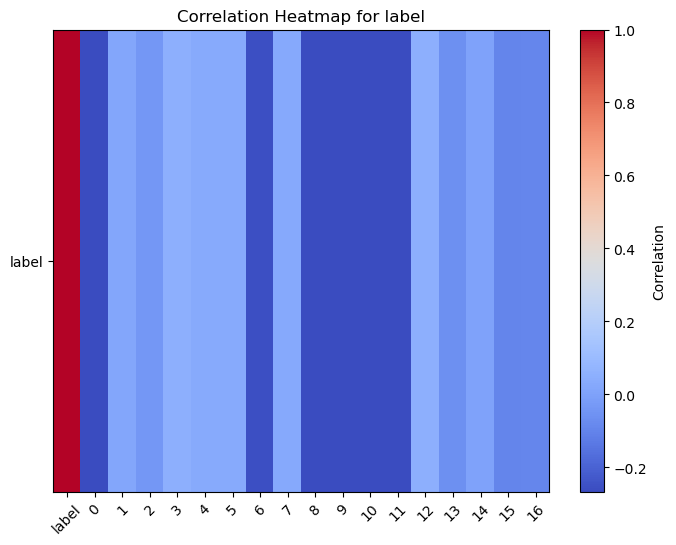

In [25]:

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
correlation = data.iloc[:,6:].corr()[['label']]
print(correlation)

# Crea una heatmap utilizzando Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow([correlation.values], cmap='coolwarm', aspect='auto')
plt.xticks(range(len(correlation)), correlation.index, rotation=45)
plt.yticks([0], ['label'])
plt.colorbar(label='Correlation')
plt.title(f'Correlation Heatmap for label')
plt.show()

In [5]:
import os

In [6]:
os.getcwd()

'C:\\Users\\damatov\\OneDrive - SeSa S.p.A\\Documenti\\Lavoro\\AI_var_group\\StefanoML\\analysis'

In [7]:
data.to_pickle('data/feat_period_12_raw_data_marco.pkl')

In [8]:
data

,month,day,hour,ref_timestamp,idx_val_below_thr,metric,label,0,1,2,...,7,8,9,10,11,12,13,14,15,16
0,10,21,0,2021-10-21 00:00:00+00:00,0,10-248-50-179,0,0.295616,4.740116e-09,-0.885352,...,0.000064,0.295521,0.295727,0.295602,1.478080,0.0,-0.000169,1.0,1.500000,0.250000
1,10,21,6,2021-10-21 06:00:00+00:00,0,10-248-50-179,0,0.294538,1.182971e-06,-1.603186,...,0.002059,0.292865,0.295727,0.295602,3.239918,0.0,0.000601,1.0,2.846018,6.099894
2,10,21,12,2021-10-21 12:00:00+00:00,0,10-248-50-179,0,0.291359,6.987567e-06,-1.633150,...,0.005371,0.287767,0.294712,0.294712,3.496313,0.0,0.001315,11.0,3.014938,7.090273
3,10,21,18,2021-10-21 18:00:00+00:00,0,10-248-50-179,0,0.288256,2.277511e-06,3.352199,...,0.000634,0.287338,0.292678,0.292678,3.459071,0.0,0.003148,7.0,3.015100,7.090861
4,10,22,0,2021-10-22 00:00:00+00:00,0,10-248-50-179,0,0.287424,9.186740e-09,0.470930,...,0.000096,0.287310,0.287656,0.287656,3.449089,0.0,-0.000124,2.0,3.015113,7.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406386,11,10,6,2021-11-10 06:00:00+00:00,0,zabbixproxyaws03,0,0.942558,1.163001e-06,2.106049,...,0.000013,0.939647,0.943039,0.939647,11.310691,0.0,-0.005339,1.0,3.015112,7.090905
406387,11,10,12,2021-11-10 12:00:00+00:00,0,zabbixproxyaws03,0,0.943009,4.393459e-10,-1.298360,...,0.000034,0.942971,0.943036,0.943020,11.316105,0.0,-0.000013,10.0,3.015113,7.090909
406388,11,10,18,2021-11-10 18:00:00+00:00,0,zabbixproxyaws03,0,0.942976,2.570209e-10,-1.068982,...,0.000024,0.942952,0.943007,0.943007,11.315713,0.0,0.000012,2.0,3.015113,7.090909
406389,11,11,0,2021-11-11 00:00:00+00:00,0,zabbixproxyaws03,0,0.942942,5.375984e-10,-1.666430,...,0.000047,0.942908,0.942970,0.942965,11.315298,0.0,0.000010,3.0,3.015113,7.090909


In [38]:
data.groupby(pd.Grouper(key='ref_timestamp', freq='W-SUN')).count()

,month,day,hour,idx_val_below_thr,metric,label,0,1,2,3,...,7,8,9,10,11,12,13,14,15,16
ref_timestamp,,,,,,,,,,,,,,,,,,,,,
2021-08-15 00:00:00+00:00,18326,18326,18326,18326,18326,18326,18326,18326,14644,14644,...,18326,18326,18326,18326,18326,18326,18326,18326,18326,18326
2021-08-22 00:00:00+00:00,30205,30205,30205,30205,30205,30205,30205,30205,24098,24098,...,30205,30205,30205,30205,30205,30205,30205,30205,30201,30201
2021-08-29 00:00:00+00:00,30233,30233,30233,30233,30233,30233,30233,30233,24152,24152,...,30233,30233,30233,30233,30233,30233,30233,30233,30231,30231
2021-09-05 00:00:00+00:00,30290,30290,30290,30290,30290,30290,30290,30290,24292,24292,...,30290,30290,30290,30290,30290,30290,30290,30290,30289,30289
2021-09-12 00:00:00+00:00,30296,30296,30296,30296,30296,30296,30296,30296,24220,24220,...,30296,30296,30296,30296,30296,30296,30296,30296,30277,30277
2021-09-19 00:00:00+00:00,30316,30316,30316,30316,30316,30316,30316,30316,24276,24276,...,30316,30316,30316,30316,30316,30316,30316,30316,30288,30288
2021-09-26 00:00:00+00:00,30520,30520,30520,30520,30520,30520,30520,30520,24422,24422,...,30520,30520,30520,30520,30520,30520,30520,30520,30491,30491
2021-10-03 00:00:00+00:00,30839,30839,30839,30839,30839,30839,30839,30839,24725,24725,...,30839,30839,30839,30839,30839,30839,30839,30839,30805,30805
2021-10-10 00:00:00+00:00,31154,31154,31154,31154,31154,31154,31154,31154,24963,24963,...,31154,31154,31154,31154,31154,31154,31154,31154,31120,31120


In [45]:
np.sqrt(17), 17**(2/3), 17**(1/3)

(4.123105625617661, 6.611489018457944, 2.571281590658235)

In [49]:
17*.4

6.800000000000001

In [50]:
os.getcwd()

'C:\\Users\\damatov\\OneDrive - SeSa S.p.A\\Documenti\\Lavoro\\AI_var_group\\StefanoML\\analysis'

In [81]:
from sklearn.linear_model import LogisticRegression

In [82]:
def monte_carlo_leave_1_out(data, n_samples, seed=0):
    group_by = ['month', 'day', 'hour']

    grouped = data.groupby(group_by)
    lun = len(grouped)
    np.random.seed(seed)
    mc = np.random.choice(lun, size=n_samples, replace=False)

    for i, (name, test) in enumerate(grouped):
        if i in mc:
            train = data.drop(test.index)
            return train.index, test.index

In [83]:
tr_idx, ts_idx = monte_carlo_leave_1_out(data, n_samples=5)

In [84]:
train_data = data.iloc[tr_idx]
test_data = data.iloc[ts_idx]

tr = train_data.drop(['month', 'day', 'hour', 'ref_timestamp', 'idx_val_below_thr', 'metric', 'label'], axis=1)
y_tr = train_data['label']
ts = test_data.drop(['month', 'day', 'hour', 'ref_timestamp', 'idx_val_below_thr', 'metric', 'label'], axis=1)
y_ts = test_data['label']

In [85]:
from sklearn.metrics import f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [86]:
%%time
named_steps = {
    'imputer': SimpleImputer(missing_values=np.nan, strategy='mean'),
    'scaler': StandardScaler(),
    'variance_threshold': VarianceThreshold(),
    'model': LogisticRegression(max_iter=1000, solver='newton-cholesky')
}

clf = Pipeline(list(named_steps.items()))
clf.fit(tr, y_tr)
y_pred = clf.predict(ts)
f1_score(y_ts, y_pred)

CPU times: total: 1.03 s
Wall time: 2.34 s


0.96